In [1]:
%matplotlib inline
%autosave 300
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (8,8)
import wave
import pyaudio
from audio2numpy import open_audio
from IPython.display import Audio
from scipy import signal
from scipy.io.wavfile import write
from scipy.signal import  firwin, freqz, firwin2, butter

Autosaving every 300 seconds


In [2]:
n = 11 # filter order - # delay line, works when odd
f = 6000 # cutoff freq
Fs = 48000
nyq = Fs/2
Wn = f/nyq

In [3]:
h_lpf = firwin(n, f, fs = Fs)

In [4]:
h_lpf = firwin(2, f, fs = Fs)
h_lpf

array([0.5, 0.5])

### b is fir response numerator

In [5]:
b = np.array([0.5,1])
gb = np.sum(np.abs(b))
b = b/gb # make repsonse at 0dB
b

array([0.33333333, 0.66666667])

### a is iir response denominator

In [6]:
a = np.array([1,0.5])
ga = np.sum(np.abs(a))
#a = a/ga # make repsonse at 0dB
a

array([1. , 0.5])

In [7]:
wl, hl = signal.freqz(b,a)

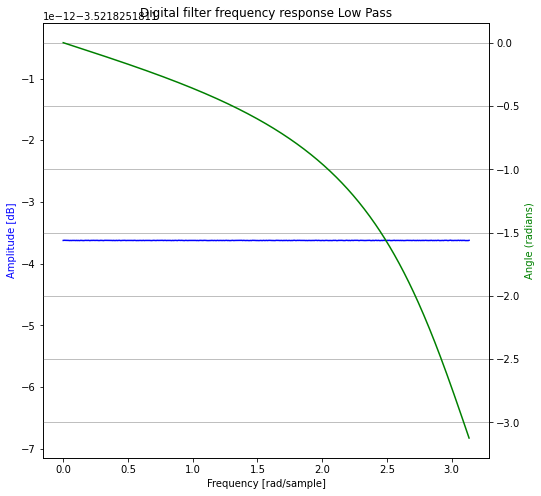

In [8]:
fig, ax1 = plt.subplots()
ax1.set_title('Digital filter frequency response Low Pass')

ax1.plot(wl, 20 * np.log10(abs(hl)), 'b')
ax1.set_ylabel('Amplitude [dB]', color='b')
ax1.set_xlabel('Frequency [rad/sample]')

ax2 = ax1.twinx()
angles = np.unwrap(np.angle(hl))
ax2.plot(wl, angles, 'g')
ax2.set_ylabel('Angle (radians)', color='g')
ax2.grid()
ax2.axis('tight')
plt.show()

### basic filter bank

In [9]:
Fs = 48000
Nyq = Fs/2
n = 8
Wn = 1000/Nyq

In [10]:
[bLow,aLow] = butter(n,Wn)
[bHi,aHi] = butter(n,Wn,btype='highpass')

In [11]:
[w,hLow] = signal.freqz(bLow,aLow,4096,fs=Fs)
[_,hHi] = signal.freqz(bHi,aHi,4096,fs=Fs)

Text(0, 0.5, 'Amplitude (dB)')

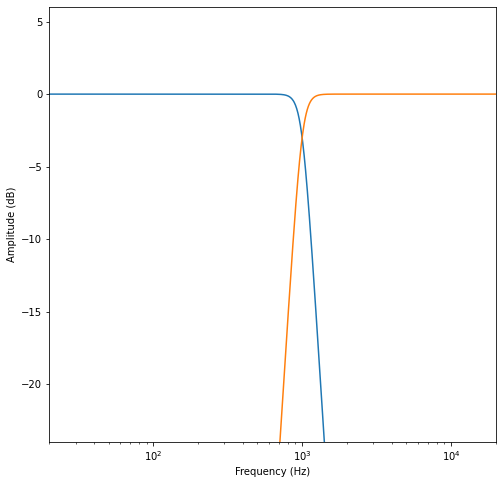

In [12]:
plt.semilogx(w,20*np.log10(abs(hLow)),w,20*np.log10(abs(hHi)))
plt.axis([20, 20000, -24, 6])
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude (dB)')

### filterbank2

In [13]:
Fs = 48000
Nyq = Fs/2
m = 2 # Filter order
numOfBands = 4

In [14]:
# Logarithmically spaced cutoff frequencies
# 2*10^1 – 2*10^4 (20–20k) Hz
freq = 2 * np.logspace(1,4,numOfBands+1)

<ipython-input-15-c3f02ead02c7>:5: RuntimeWarning: divide by zero encountered in log10
  plt.semilogx(w,20*np.log10(abs(h)))
<ipython-input-15-c3f02ead02c7>:5: RuntimeWarning: divide by zero encountered in log10
  plt.semilogx(w,20*np.log10(abs(h)))
<ipython-input-15-c3f02ead02c7>:5: RuntimeWarning: divide by zero encountered in log10
  plt.semilogx(w,20*np.log10(abs(h)))
<ipython-input-15-c3f02ead02c7>:5: RuntimeWarning: divide by zero encountered in log10
  plt.semilogx(w,20*np.log10(abs(h)))


Text(0, 0.5, 'Amplitude (dB)')

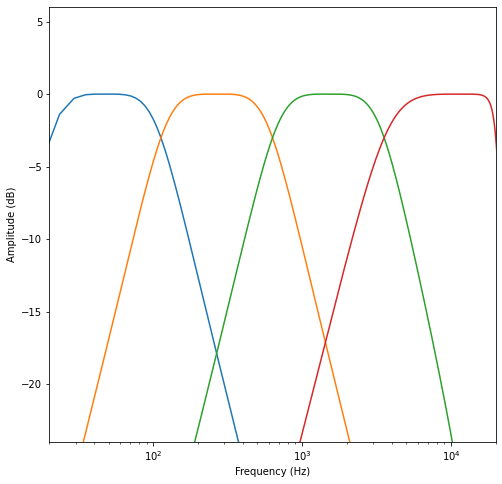

In [15]:
for band in range(numOfBands):
    Wn = np.array([freq[band] , freq[band+1]]) / Nyq
    b,a=butter(m,Wn,btype='bandpass')
    [w,h] = freqz(b,a,4096,fs=Fs)
    plt.semilogx(w,20*np.log10(abs(h)))

plt.axis([20, 20000, -24, 6])
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude (dB)')

### using the filter

In [16]:
filename = "textbookcode-master\Ch_13\AcGtr.wav"
[x,Fs] = open_audio(filename)
Nyq = Fs/2
m = 4 # Order of the filter
freqHz = 500 #frequency in Hz
Wn = freqHz/Nyq
[b,a] = butter(m,Wn)
y = signal.lfilter(b,a,x)
Audio(y,rate=Fs)

### fir as iir filter

In [17]:
filename = "textbookcode-master\Ch_13\AcGtr.wav"
[x,Fs] = open_audio(filename)

In [18]:
Nyq = Fs/2
m = 4 # Order of the filter
freqHz = 2000 # frequency in Hz

In [19]:
Wn = freqHz/Nyq
b,a = butter(m,Wn)

<StemContainer object of 3 artists>

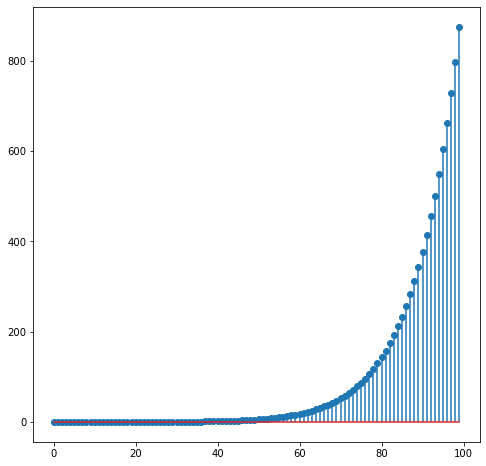

In [20]:
t,h = signal.impulse([b,a]) # Approximate system
y = np.convolve(x,h)
plt.stem(h)

In [21]:
Audio(y,rate=Fs)

### biquad

In [22]:
def biquadFilter(x, Fs, f0, Q, dbGain, ftype, form):
    # Initial parameters
    N = len(x)
    out = np.zeros(N)
    
    # Intermediate variables
    
    w0 = 2*np.pi*f0/Fs # Angular freq. (radians/sample)
    alpha = np.sin(w0)/(2*Q) # Filter width
    A = np.sqrt(10**(dBGain/20)) # Amplitude
    
    #######################################
    #TYPE – LPF,HPF,BPF,APF,HSF,LSF,PKF,NCH
    #######################################
    
    #––––––––––––––––––––––
    # LPF
    #––––––––––––––––––––––
    if ftype =='lpf':
        b0 = (1 - np.cos(w0))/2
        b1 = 1 - np.cos(w0)
        b2 = (1 - np.cos(w0))/2
        a0 = 1 + alpha
        a1 = -2*np.cos(w0)
        a2 = 1 - alpha
        print("lpf")
    #––––––––––––––––––––––
    # HPF
    #––––––––––––––––––––––
    elif ftype == 'hpf':
        b0 = (1 + np.cos(w0))/2
        b1 = -(1 + np.cos(w0))
        b2 = (1 + np.cos(w0))/2
        a0 = 1 + alpha
        a1 = -2*np.cos(w0)
        a2 = 1 - alpha
    #––––––––––––––––––––––
    # Peaking Filter
    #––––––––––––––––––––––
    elif ftype == 'pkf':
        b0 = 1 + alpha*A
        b1 = -2*np.cos(w0)
        b2 = 1 - alpha*A
        a0 = 1 + alpha/A
        a1 = -2*np.cos(w0)
        a2 = 1 - alpha/A
    #––––––––––––––––––––––
    # Band–Pass Filter 1
    #––––––––––––––––––––––
    # Constant skirt gain, peak gain = Q
    elif ftype == 'bp1':
        b0 = np.sin(w0)/2
        b1 = 0
        b2 = -np.sin(w0)/2
        a0 = 1 + alpha
        a1 = -2*np.cos(w0)
        a2 = 1 - alpha
    #––––––––––––––––––––––
    # Band–Pass Filter 2
    #––––––––––––––––––––––
    # Constant 0 dB peak gain
    elif ftype == 'bp2':
        b0 = alpha
        b1 = 0
        b2 = -alpha
        a0 = 1 + alpha
        a1 = -2*np.cos(w0)
        a2 = 1 - alpha
    #––––––––––––––––––––––
    # Notch Filter
    #––––––––––––––––––––––
    elif ftype == 'nch':
        b0 = 1
        b1 = -2*np.cos(w0)
        b2 = 1
        a0 = 1 + alpha
        a1 = -2*np.cos(w0)
        a2 = 1 - alpha
    #––––––––––––––––––––––
    # All–Pass Filter
    #––––––––––––––––––––––
    elif ftype == 'apf':
        b0 = 1 - alpha
        b1 = -2*np.cos(w0)
        b2 = 1 + alpha
        a0 = 1 + alpha
        a1 = -2*np.cos(w0)
        a2 = 1 - alpha
    #––––––––––––––––––––––
    # Low–Shelf Filter
    #––––––––––––––––––––––
    elif ftype == 'lsf':
        b0 = A*((A+1) - (A-1)*np.cos(w0) + 2*np.sqrt(A)*alpha)
        b1 = 2*A*((A-1) - (A+1)*np.cos(w0))
        b2 = A*((A+1) - (A-1)*np.cos(w0) - 2*np.sqrt(A)*alpha)
        a0 = (A+1) + (A-1)*np.cos(w0) + 2*np.sqrt(A)*alpha
        a1 = -2*((A-1) + (A+1)*np.cos(w0))
        a2 = (A+1) + (A-1)*np.cos(w0) - 2*np.sqrt(A)*alpha
    #––––––––––––––––––––––
    # High–Shelf Filter
    #––––––––––––––––––––––
    elif ftype =='hsf':
        b0 = A*( (A+1) + (A-1)*np.cos(w0) + 2*np.sqrt(A)*alpha)
        b1 = -2*A*((A-1) + (A+1)*np.cos(w0))
        b2 = A*((A+1) + (A-1)*np.cos(w0) - 2*np.sqrt(A)*alpha)
        a0 = (A+1) - (A-1)*np.cos(w0) + 2*np.sqrt(A)*alpha
        a1 = 2*((A-1) - (A+1)*np.cos(w0))
        a2 = (A+1) - (A-1)*np.cos(w0) - 2*np.sqrt(A)*alpha
    # Otherwise, no filter
    else:
        b0 = 1
        a0 = 1
        b1 = 0
        b2 = 0
        a1 = 0
        a2 = 0

    # Topology – Direct Form I, II, Transposed II
    
    # Direct Form I
    if (form == 1): 
        # Initial conditions
        x2 = 0
        x1 = 0
        y2 = 0
        y1 = 0
        
        for n in range(N):
            out[n] = (b0/a0)*x[n]+(b1/a0)*x1+(b2/a0)*x2+(-a1/a0)*y1+(-a2/a0)*y2
            x2 = x1
            x1 = x[n]
            y2 = y1
            y1 = out[n]
    
    # Direct Form II
    elif (form == 2):
        # w1 & w2 are delayed versions of "w"
        w1 = 0 
        w2 = 0
        for n in range(N):
            w = x[n] + (-a1/a0)*w1 + (-a2/a0)*w2
            out[n] = (b0/a0)*w + (b1/a0)*w1 + (b2/a0)*w2
            w2 = w1
            w1 = w
    
    # Transposed Direct Form II
    elif (form == 3): 
        # d1 & d2 are outputs of the delay blocks
        d1 = 0
        d2 = 0
        print("filter3")
        for n in range(N):
            out[n] = (b0/a0)*x[n] + d1
            d1 = (b1/a0)*x[n] + (-a1/a0)*out[n] + d2
            d2 = (b2/a0)*x[n] + (-a2/a0)*out[n]
    
    # No filtering
    else: 
        out = x
        
    return out

In [23]:
filename = "textbookcode-master\Ch_13\AcGtr.wav"
[x,Fs] = open_audio(filename)

# Filter parameters
#Fs = 48000
f = 1000 # Frequency in Hz
Q = 0.707
dBGain = -6
# FILTER TYPE >>> lpf,hpf,pkf,apf,nch,hsf,lsf,bp1,bp2
ftype = 'lpf'
# TOPOLOGY >>> 1 = Direct Form I, 2 = II, 3 = Transposed II
form = 3
y = biquadFilter(x,Fs,f,Q,dBGain,ftype,form)
Audio(y,rate=Fs)

lpf
filter3


In [24]:
x = np.zeros(4096)

# Filter parameters
Fs = 48000
f = 1000 # Frequency in Hz
Q = 0.707
dBGain = -6
# FILTER TYPE >>> lpf,hpf,pkf,apf,nch,hsf,lsf,bp1,bp2
ftype = 'lpf'
# TOPOLOGY >>> 1 = Direct Form I, 2 = II, 3 = Transposed II
form = 3
y = biquadFilter(x,Fs,f,Q,dBGain,ftype,form)

lpf
filter3


In [25]:
# Plot amplitude response of filter
w, h = signal.freqz(y,1,4096, fs=Fs)

<ipython-input-26-b30168fa9f8b>:1: RuntimeWarning: divide by zero encountered in log10
  plt.semilogx(w,20*np.log10(np.abs(h)))


Text(0, 0.5, 'Amplitude (dB)')

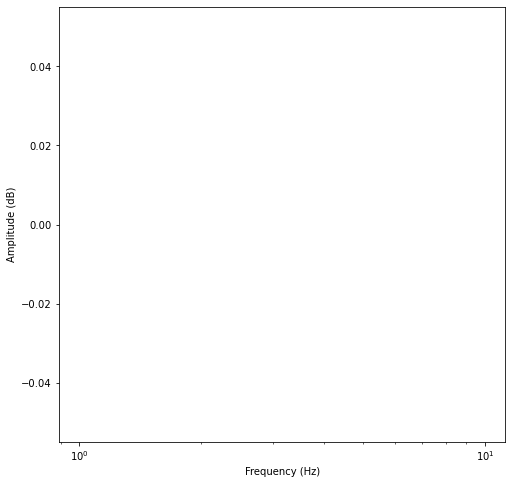

In [26]:
plt.semilogx(w,20*np.log10(np.abs(h)))
#plt.axis([20, 20000, -20, 15])
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude (dB)')

### slewrate distortion

In [27]:
def slewRateDistortion(inx,Fs,maxFreq):
    Ts = 1/Fs
    peak = 1
    slewRate = maxFreq*2*np.pi*peak # Convert freq to slew rate
    slope = slewRate*Ts # Convert slew rate to slope/sample
    out = np.zeros(len(inx)) # Total number of samples
    prevOut = 0 # Initialize feedback delay sample
    
    for n in range(len(inx)):
        # Determine the change between samples
        dlta = inx[n] - prevOut
        if dlta > slope: # Don't let dlta exceed max slope
            dlta = slope
        elif dlta < -slope:
        #else:
            dlta = -slope
    
        out[n] = prevOut + dlta
        prevOut = out[n] # Save current "out" for next loop
    
    return out


(0.0, 1.0, -1.1, 1.1)

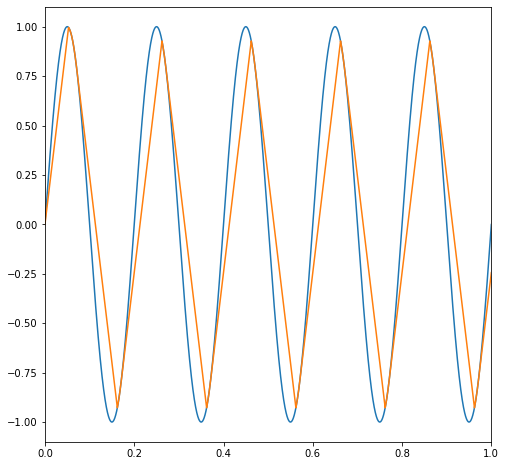

In [28]:
Fs = 48000
Ts = 1/Fs
f = 5 # Low frequency for sake of plotting
t = np.arange(0,1,Ts)
x = np.sin(2*np.pi*f*t) # Example 1: Sine Wave
#x = signal.square(2*np.pi*f*t) # Example 2: Square Wave
maxFreq = 3
# Note: if maxFreq ≥ "f" of sine wave, then no distortion
# If maxFreq < "f" of input, then slew rate distortion
y = slewRateDistortion(x,Fs,maxFreq)
plt.plot(t,x)
plt.plot(t,y)
plt.axis([0, 1, -1.1, 1.1])
#plt.legend('Input','Output');


### iir pink noise

In [29]:
Fs = 48000 #Sampling rate
Nyq = Fs/2 # Nyquist frequency for normalization
sec = 5 # 5 seconds of noise
white = np.random.randn(sec*Fs)

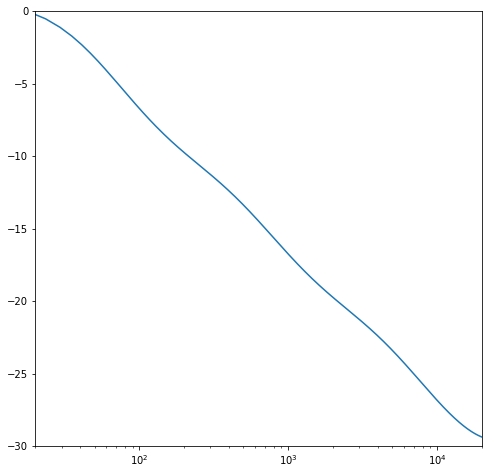

In [30]:
b = [0.049922035, -0.095993537, 0.050612699, -0.004408786]
a = [1, -2.494956002, 2.017265875, -0.522189400]
[F,H] = signal.freqz(b,a,4096,fs=Fs)
plt.semilogx(F,20*np.log10(np.abs(H)))
plt.axis([20, 20000, -30, 0])
# Create pink noise by filtering white noise
pink = signal.lfilter(b,a,white)

In [31]:
Audio(pink,rate=Fs)

### LUFS

In [39]:
def lufs(x):
    # Number of samples
    N = len(x)
    # Determine whether mono or stereo
    numOfChannels = np.ndim(x)
    
    # Initialize pre–filter
    b0 = 1.53512485958697
    a1 = -1.69065929318241
    b1 = -2.69169618940638
    a2 = 0.73248077421585
    b2 = 1.19839281085285
    a0 = 1
    
    b = np.array([b0, b1,b2])
    a = np.array([a0,a1,a2])
    
    # Perform pre–filtering
    w = np.zeros(np.shape(x))
    

In [40]:
filename = "textbookcode-master\Ch_13\RhythmGuitar.wav"
[x,Fs] = open_audio(filename)

In [41]:
# Number of samples
N = len(x)
# Determine whether mono or stereo
numOfChannels = np.ndim(x)

# Initialize pre–filter
b0 = 1.53512485958697
a1 = -1.69065929318241
b1 = -2.69169618940638
a2 = 0.73248077421585
b2 = 1.19839281085285
a0 = 1

b = np.array([b0, b1,b2])
a = np.array([a0,a1,a2])

# Perform pre–filtering
w = np.zeros(np.shape(x))

w

array([0., 0., 0., ..., 0., 0., 0.])

In [42]:
numOfChannels

1

In [45]:
w.shape

(989957,)

In [48]:
channel = 1
y = signal.lfilter(b,a,w)
y

array([0., 0., 0., ..., 0., 0., 0.])

In [ ]:
for channel in range(numOfChannels): # Loop in case it is stereo
        w[:,channel] = signal.lfilter(b,a,x[:,channel]);
    
    # RLB filter
    b0 = 1.0
    a1 = -1.99004745483398
    b1 = -2.0
    a2 = 0.99007225036621
    b2 = 1.0
    a0 = 1
    
    b = np.array([b0, b1,b2])
    a = np.array([a0,a1,a2])
    
    # Perform RLB filtering
    y = np.zeros(np.shape(x))

    for channel in range(numOfChannels):
        y[:,channel] = signal.lfilter(b,a,w[:,channel])

    # Perform mean–square amplitude analysis
    z = np.zeros(numOfChannels)
    
    for channel in range(numOfChannels):
        # Add together the square of the samples,
        # then divide by the number of samples
        z[channel] = np.sum(y[:,channel]**2)/N
    
    # Determine loudness (dB) by summing all channels
    loudness = -0.691 + 10 * np.log10(np.sum(z))


In [33]:
filename = "textbookcode-master\Ch_13\RhythmGuitar.wav"
[x,Fs] = open_audio(filename)

In [34]:
np.ndim(x)


1

In [35]:
loudnessGuitar = lufs(x)



IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [ ]:
# Example 2 – Stereo drums
sig2 = audioread('stereoDrums.wav');
loudnessDrums = lufs(sig2)
% Example 3 – Filtered noise signal provide by EBU for verification
fnm='EBU–reference_listening_signal_pinknoise_500Hz_2kHz_R128.wav';
sig3 = audioread(fnm);
loudnessNoise = lufs(sig3) % Should equal –23 LUFS
% Example 3 – Sine wave provided by EBU for verification
sig4 = audioread('1kHz Sine –40 LUFS–16bit.wav');
loudnessSine = lufs(sig4) % Should equal –40 LUFS

In [37]:
data = np.array([[[1,2,3],[4,5,6],[7,8,9]],[[1,2,3],[4,5,6],[7,8,9]]])
data

array([[[1, 2, 3],
        [4, 5, 6],
        [7, 8, 9]],

       [[1, 2, 3],
        [4, 5, 6],
        [7, 8, 9]]])

In [38]:
data.shape

(2, 3, 3)

In [ ]:
d = np.zeros(np.shape(data))

In [ ]:
d

In [ ]:
data[0,:]

In [ ]:
data[1:,1] = np.array([22,33])

In [ ]:
data